In [1]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import silhouette_score
from scipy.stats import entropy
from collections import defaultdict
from functools import reduce
import joblib
from joblib import load
import os
import gc

import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse

from joblib import Parallel, delayed
from scipy.stats import multivariate_normal

from sklearn.cluster import KMeans
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import gpytorch
from gpytorch.kernels import MaternKernel, PeriodicKernel, LinearKernel, ScaleKernel, MultitaskKernel, RBFKernel, AdditiveKernel
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy, MultitaskVariationalStrategy, LMCVariationalStrategy
from gpytorch.distributions import MultitaskMultivariateNormal
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.mlls import VariationalELBO, ExactMarginalLogLikelihood
from gpytorch.means import ConstantMean
from gpytorch.settings import cholesky_jitter, fast_pred_var


In [2]:
class MultitaskGPModel(ApproximateGP):
    def __init__(self, num_latents, num_tasks, inducing_points, nu_height, nu_lonlat, daily_period, yearly_period):
        variational_distribution= gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        variational_strategy= gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks= num_tasks,
            num_latents= num_latents,
            latent_dim= -1
        )

        super().__init__(variational_strategy)

        self.mean_module= gpytorch.means.ConstantMean(batch_shape= torch.Size([num_latents]))

        self.daily_kernel= PeriodicKernel(period_length=daily_period, batch_shape= torch.Size([num_latents]), active_dim=[3])
        self.yearly_kernel= PeriodicKernel(period_length=yearly_period, batch_shape= torch.Size([num_latents]), active_dim=[4])
        self.hight_kernel= MaternKernel(nu=nu_height, batch_shape= torch.Size([num_latents]), active_dim=[0])
        self.lonLat_kernel= MaternKernel(nu=nu_lonlat, batch_shape= torch.Size([num_latents]), active_dim=[1,2])
        self.conter_kernel= RBFKernel(batch_shape= torch.Size([num_latents]), active_dim=[5])
        
        self.covar_module= ScaleKernel(
            AdditiveKernel(
                self.daily_kernel,
                self.yearly_kernel,
                self.lonLat_kernel,
                self.hight_kernel,
                self.conter_kernel
            ),
            batch_shape= torch.Size([num_latents])
        )

    def forward(self, x):
        mean_x= self.mean_module(x)
        covar_x= self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
def generate_conditional_samples(
    station_name: str,
    input_df: pd.DataFrame,
    results_dict: dict,
    n_samples: int = 10,
    datetime_column: str = "MESS_DATUM",
    device: torch.device = torch.device("cpu")
):
    """
    Erzeugt bedingte Stichproben aus einem trainierten Multitask GP für eine gegebene Station.

    Parameter:
    - station_name: Name der Station (wie in results_dict gespeichert)
    - input_df: Pandas DataFrame mit Eingabedaten (inkl. datetime-Spalte)
    - results_dict: Dict mit Modell, Scaler und Daten
    - n_samples: Anzahl der bedingten Stichproben
    - datetime_column: Name der Zeitspalte (default: "MESS_DATUM")
    - device: Torch-Gerät (GPU/CPU)

    Rückgabe:
    - samples_rescaled: Array [n_samples, len(input_df), num_tasks]
    """
    
    # Sicherstellen, dass datetime korrekt ist
    df = input_df.copy()
    df[datetime_column] = pd.to_datetime(df[datetime_column])
    
    # Features erzeugen (Day of year, hour, counter)
    df["day_of_year"] = df[datetime_column].dt.dayofyear
    df["hour"] = df[datetime_column].dt.hour
    df["time_hours"] = np.arange(len(df))  # Optional: laufender Index

    # Features für Modell vorbereiten
    X_input = df[features].values.astype(np.float32)

    # Skalieren
    X_input_np = results_dict[station_name]["scalerX"].transform(X_input)
    X_input_tensor = torch.tensor(X_input_np, dtype=torch.float32).to(device)

    # Modell laden
    model = results_dict[station_name]["model"]
    likelihood = results_dict[station_name]["likelihood"]
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_jitter(1e-4):
        latent_pred = model(X_input_tensor)
        predictive = likelihood(latent_pred)
        samples = predictive.rsample(torch.Size([n_samples]))  # [n_samples, batch, num_tasks]

    # Rückskalieren
    samples_np = samples.cpu().numpy().reshape(-1, samples.shape[-1])
    samples_rescaled = results_dict[station_name]["scalerY"].inverse_transform(samples_np)
    samples_rescaled = samples_rescaled.reshape(n_samples, X_input.shape[0], -1)

    return samples_rescaled

In [4]:
def evaluate_gp_model(model, likelihood, X_test_np, y_test_np, num_data, device, batch_size=1024):
    model.eval()
    likelihood.eval()

    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32)

    mll_total = 0.0
    mse_total = 0.0
    n_total = 0

    with torch.no_grad(), fast_pred_var(), cholesky_jitter(1e-3):
        for i in range(0, len(X_test_tensor), batch_size):
            X_batch = X_test_tensor[i:i+batch_size].to(device)
            y_batch = y_test_tensor[i:i+batch_size].to(device)

            output = model(X_batch)
            pred = likelihood(output)

            # Teilweise NLL berechnen
            mll = VariationalELBO(likelihood, model, num_data=num_data)
            batch_nll = -mll(output, y_batch).item() * len(X_batch)
            mll_total += batch_nll

            # MSE
            mse_total += F.mse_loss(pred.mean, y_batch, reduction="sum").item()
            n_total += len(X_batch)

            del X_batch, y_batch, output, pred
            torch.cuda.empty_cache()
            gc.collect()

    return {
        "NLL": mll_total / n_total,
        "MSE": mse_total / n_total
    }

In [5]:
def get_model_outputs_in_batches(model, X_tensor, batch_size=1024):
    model.eval()
    outputs = []

    loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size)

    with torch.no_grad():
        for batch in loader:
            x_b = batch[0].to(X_tensor.device)
            output = model(x_b)
            outputs.append(output)

    return outputs

In [26]:
def plot_gp_time_series_all_targets_counter(
    model, likelihood, df_test, scalerX, scalerY,
    features, targets,
    start_counter=0, n_steps=365,
    counter_feature="time_hours",
    batch_size=512,
    title_prefix=""
):
    device = torch.device("cpu")

    df_test = df_test.copy()
    df_test = df_test.sort_values(counter_feature)

    # Schneide n_steps ab start_counter aus df_test
    df_sub = df_test[df_test[counter_feature] >= start_counter].iloc[:n_steps]
    if len(df_sub) == 0:
        print("⚠️ Keine Daten ab diesem Start Counter gefunden.")
        return

    # Inputdaten vorbereiten
    X_np = scalerX.transform(df_sub[features].values.astype(np.float32))
    y_np = scalerY.transform(df_sub[targets].values.astype(np.float32))

    X_tensor = torch.tensor(X_np, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_np, dtype=torch.float32).to(device)

    model.eval()
    likelihood.eval()
    outputs = get_model_outputs_in_batches(model, X_tensor, batch_size=batch_size)

    means = torch.cat([o.mean for o in outputs], dim=0)
    stds = torch.cat([o.stddev for o in outputs], dim=0)

    # Rückskalieren
    means_orig = scalerY.inverse_transform(means.cpu().numpy())
    stds_orig = stds.detach().cpu().numpy()
    y_true_orig = scalerY.inverse_transform(y_tensor.cpu().numpy())

    # x-Achse aus dem Counter Feature
    counter_vals = df_sub[counter_feature].values

    fig, axs = plt.subplots(len(targets), 1, figsize=(14, 3 * len(targets)), sharex=True)

    for i, target in enumerate(targets):
        ax = axs[i]

        ax.plot(counter_vals, means_orig[:, i], label="Prediction", color="blue")
        ax.fill_between(
            counter_vals,
            means_orig[:, i] - 2 * stds_orig[:, i],
            means_orig[:, i] + 2 * stds_orig[:, i],
            alpha=0.3, label="±2σ", color="blue"
        )
        ax.plot(counter_vals, y_true_orig[:, i], label="Ground Truth", color="black", linestyle="--")

        ax.set_ylabel(target)
        ax.legend(loc="upper right")
        ax.grid(True)

    plt.suptitle(f"{title_prefix} GP-Vorhersage mit Unsicherheiten", fontsize=16)
    plt.xlabel(counter_feature)
    plt.tight_layout()
    plt.show()

In [7]:
def compute_sharpness(model, X_tensor, batch_size=1024):
    model.eval()
    outputs = get_model_outputs_in_batches(model, X_tensor, batch_size=batch_size)

    stds = torch.cat([o.stddev for o in outputs], dim=0)  # [N, num_targets]
    sharpness_per_target = stds.mean(dim=0).detach().cpu().numpy()  # Mittelwert Std pro Ziel

    return sharpness_per_target

In [8]:
def plot_sharpness_heatmap(results_dict, targets, batch_size=1024):
    sharpness_matrix = {}

    for station_name, result in results_dict.items():
        model = result["model"]
        X_val_np = result["X_val_np"]
        X_tensor = torch.tensor(X_val_np, dtype=torch.float32).to(device)

        sharpness_vals = compute_sharpness(model, X_tensor, batch_size=batch_size)
        sharpness_matrix[station_name] = sharpness_vals

    sharpness_df = pd.DataFrame.from_dict(sharpness_matrix, orient='index', columns=targets)

    plt.figure(figsize=(12, 7))
    sns.heatmap(sharpness_df, annot=True, fmt=".3f", cmap="YlOrRd", cbar_kws={'label': 'Sharpness (avg. stddev)'})
    plt.title("Sharpness (Uncertainty Precision) per Station and Target")
    plt.xlabel("Zielvariable")
    plt.ylabel("Station")
    plt.tight_layout()
    plt.show()


In [9]:
def get_model_samples_in_batches(model, X_tensor, num_samples=100, batch_size=512):
    model.eval()
    samples_list = []

    loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size)

    with torch.no_grad():
        for batch in loader:
            x_b = batch[0].to(X_tensor.device)
            posterior = model(x_b)
            samples = posterior.rsample(torch.Size([num_samples]))  # shape: [S, B, T]
            samples_list.append(samples.cpu())  # Optional: to('cpu') to avoid GPU issues

    return torch.cat(samples_list, dim=1)  # [num_samples, N, num_targets]

In [10]:

def evaluate_gp_consistency_with_ridge(
    features: list,
    targets: list,
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    synthetic_samples: np.ndarray,  # shape: [N, len(targets)]
    scalerY = None
):
    """
    Vergleicht die Generalisierungsleistung von Ridge-Regressoren,
    die auf realen Daten trainiert wurden und auf:
    1. realen Testdaten
    2. synthetisch generierten GP-Daten
    angewendet werden.

    Args:
        features (list): Feature-Namen inkl. Zielgrößen
        targets (list): Nur Zielgrößen (subset von features)
        df_train (pd.DataFrame): Trainingsdaten (real)
        df_test (pd.DataFrame): Testdaten (real)
        synthetic_samples (np.ndarray): vom GP generierte y-Samples
        scalerY: optionaler Rücktransformierer

    Returns:
        linearModels: dict[target] → Ridge-Modell
        mseReal: MSE auf echten Testdaten
        mseSynthetic: MSE auf GP-Daten
    """
    linearModels = {}
    mseReal = []
    mseSynthetic = []

    df_synthetic = df_test.copy()
    for i, target in enumerate(targets):
        if scalerY:
            df_synthetic[target] = scalerY.inverse_transform(synthetic_samples)[:, i]
        else:
            df_synthetic[target] = synthetic_samples[:, i]

    for target in targets:
        input_features = [f for f in features if f != target]

        X_train = df_train[input_features]
        y_train = df_train[target]
        X_test = df_test[input_features]
        y_test = df_test[target]
        X_syn = df_synthetic[input_features]
        y_syn = df_synthetic[target]

        ridge = Ridge(alpha=1.0)
        ridge.fit(X_train, y_train)

        y_pred_real = ridge.predict(X_test)
        y_pred_syn = ridge.predict(X_syn)

        mse_r = mean_squared_error(y_test, y_pred_real)
        mse_s = mean_squared_error(y_syn, y_pred_syn)

        print(f"🎯 Target: {target}")
        print(f"  🔹 Real Test MSE:      {mse_r:.4f}")
        print(f"  🔸 Synthetic MSE:      {mse_s:.4f}\n")

        mseReal.append(mse_r)
        mseSynthetic.append(mse_s)
        linearModels[target] = ridge

    return linearModels, mseReal, mseSynthetic

In [11]:
rowwiseDfOriginal = pd.read_pickle("..\\data\\rowwiseDf.pkl")

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
Stations= ['LastYear', "Erfurt-Weimar", "Schmücke", "Eisenach", "Artern", "Neuhaus am Rennweg","Meiningen", "Leinefelde", "Osterfeld"]
features = ['Stationshoehe','geoBreite','geoLaenge', 'hour', 'day_of_year', 'time_hours']
targets = ['TT_TU','RF_TU','  R1','  P0','   F']

In [14]:
rowwiseDf= rowwiseDfOriginal.drop(columns= ['STATIONS_ID', 'RS_IND', 'WRTR', '   P', '   D'])
rowwiseDf['day_of_year']= rowwiseDf['MESS_DATUM'].dt.dayofyear

In [15]:
reducedDf= rowwiseDf.copy()
reducedDf['MESS_DATUM']= pd.to_datetime(reducedDf['MESS_DATUM'])

maxDate= reducedDf['MESS_DATUM'].max()
cutoffDate= maxDate - pd.DateOffset(years= 5)

reducedDf= reducedDf[(reducedDf['Stationsname'].isin(Stations)) & (reducedDf['MESS_DATUM'] >= cutoffDate)]
reducedDf= reducedDf.drop(columns= ['day', 'month', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'day_of_year_sin', 'day_of_year_cos'])
reducedDf['time_hours'] = (reducedDf['MESS_DATUM'] - reducedDf['MESS_DATUM'].min()).dt.total_seconds() / 3600

In [16]:
model_dir = "..\\data\\rowWiseModelFinal\\GP"

In [17]:
reducedDf.columns

Index(['MESS_DATUM', 'TT_TU', 'RF_TU', '  R1', '  P0', '   F', 'Stationshoehe',
       'geoBreite', 'geoLaenge', 'Stationsname', 'hour', 'day_of_year',
       'time_hours'],
      dtype='object')

In [22]:
results_dict = {}
for station in Stations:
    if station == 'LastYear':
        # Split nach Datum: letzte 10% als Test
        maxDate = reducedDf['MESS_DATUM'].max()
        cutoffDate = maxDate - pd.DateOffset(years=1)
        df_test = reducedDf[reducedDf['MESS_DATUM'] >= cutoffDate]
        df_train = reducedDf[reducedDf['MESS_DATUM'] < cutoffDate]
        station_name = "None"
    else:
        # Split nach Station
        df_test = reducedDf[reducedDf['Stationsname'] == station]
        df_train = reducedDf[reducedDf['Stationsname'] != station]
        station_name = station

    drop_cols = ['MESS_DATUM', 'Stationsname']
    df_train = df_train.drop(columns=drop_cols, errors='ignore')
    df_test = df_test.drop(columns=drop_cols, errors='ignore')

    X_train= df_train[features].values.astype(np.float32)
    y_train= df_train[targets].values.astype(np.float32)

    X_test= df_test[features].values.astype(np.float32)
    y_test= df_test[targets].values.astype(np.float32)

    scalerX = StandardScaler()
    X_train_np = scalerX.fit_transform(X_train)
    X_val_np = scalerX.transform(X_test)
    scalerY = StandardScaler()
    y_train_np = scalerY.fit_transform(y_train)
    y_val_np = scalerY.transform(y_test)
    num_inducing = 1000    
    subset_idx = np.random.choice(X_train_np.shape[0], min(10000, X_train_np.shape[0]), replace=False)
    X_kmeans_np = X_train_np[subset_idx]

    kmeans = KMeans(n_clusters=num_inducing, n_init=10, random_state=21)
    kmeans.fit(X_kmeans_np)
    inducing_points = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

    model = MultitaskGPModel(
        inducing_points = inducing_points,
        nu_lonlat = 1.5,
        nu_height = 0.5,
        daily_period = 24,
        yearly_period = 365.25,
        num_tasks= 5,
        num_latents = 6
    ).to(device)

    model.load_state_dict(torch.load(f"{model_dir}\\model_{station}.pt", map_location=device))
    model.eval()

    likelihood = MultitaskGaussianLikelihood(num_tasks=5).to(device)
    likelihood.load_state_dict(torch.load(f"{model_dir}\\likelihood_{station}.pt", map_location=device))
    likelihood.eval()

    results_dict[station_name] = {
    "model": model,
    "likelihood": likelihood,
    "scalerX": scalerX,
    "scalerY": scalerY,
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
    "X_train_np": X_train_np,
    "y_train_np": y_train_np,
    "X_val_np": X_val_np,
    "y_val_np": y_val_np,
    "df_train": df_train,
    "df_test": df_test
}

In [20]:
my_input_df = pd.DataFrame([{
    'MESS_DATUM': "21.10.2023",
    'Stationshoehe': 244,
    'geoBreite': 51.0872,
    'geoLaenge': 11.9293
}])

In [21]:
sampled = generate_conditional_samples(
    station_name="Osterfeld",
    input_df=my_input_df,  # Muss Spalte "MESS_DATUM" enthalten!
    results_dict=results_dict,
    n_samples=20,
    device = torch.device("cpu")  # oder "cpu"
)

print(sampled.shape)

C:\Users\johan\AppData\Local\Temp\ipykernel_13280\2112535446.py:26: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[datetime_column] = pd.to_datetime(df[datetime_column])


(20, 1, 5)


In [19]:
model_scores = {}

for station, data in results_dict.items():
    score = evaluate_gp_model(
        model=data["model"],
        likelihood=data["likelihood"],
        X_test_np=data["X_val_np"],
        y_test_np=data["y_val_np"],
        num_data=data["X_train_np"].shape[0],
        device=device
    )
    model_scores[station] = score

In [20]:
# Sortiere nach NLL
sorted_models = sorted(model_scores.items(), key=lambda x: x[1]["NLL"])

# Ausgabe
for rank, (station, score) in enumerate(sorted_models, start=1):
    print(f"{rank}. Station: {station} | NLL: {score['NLL']:.4f} | MSE: {score['MSE']:.4f}")

1. Station: Neuhaus am Rennweg | NLL: 32.2004 | MSE: 7.9928
2. Station: Eisenach | NLL: 39.0843 | MSE: 3.9523
3. Station: Erfurt-Weimar | NLL: 40.4038 | MSE: 4.5990
4. Station: Schmücke | NLL: 45.6716 | MSE: 12.6250
5. Station: None | NLL: 45.7027 | MSE: 5.4731
6. Station: Leinefelde | NLL: 49.4030 | MSE: 3.6897
7. Station: Osterfeld | NLL: 53.4777 | MSE: 4.1612
8. Station: Meiningen | NLL: 54.3377 | MSE: 3.5601
9. Station: Artern | NLL: 61.7617 | MSE: 5.4217


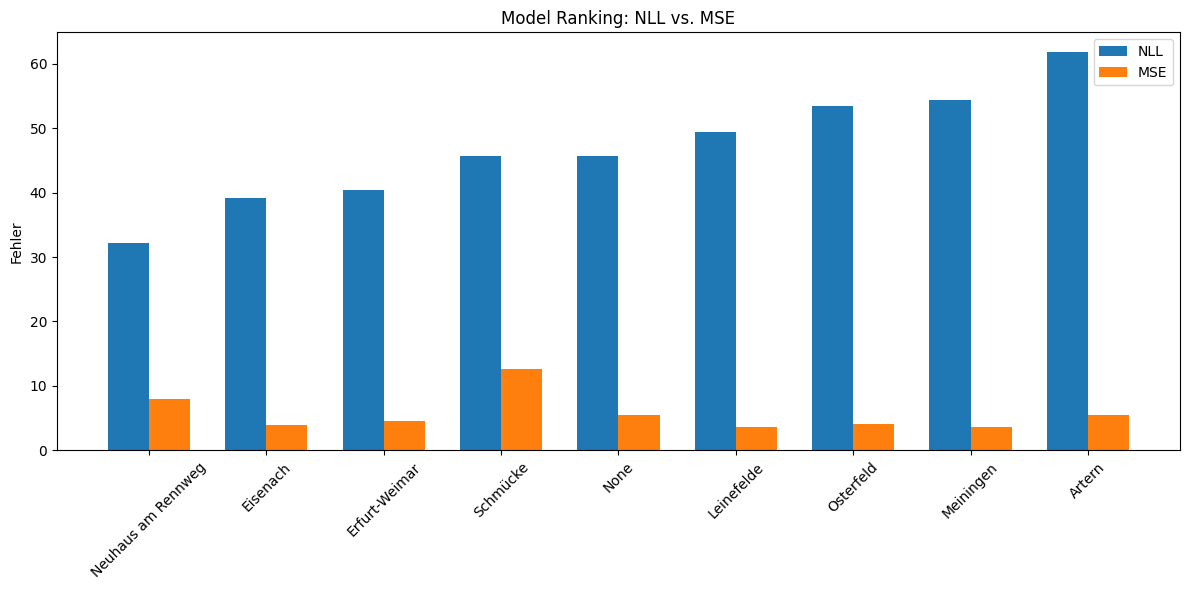

In [21]:
stations = [k for k, _ in sorted_models]
nlls = [v["NLL"] for _, v in sorted_models]
mses = [v["MSE"] for _, v in sorted_models]

x = np.arange(len(stations))  # Positionen auf der X-Achse
width = 0.35  # Breite der Balken

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, nlls, width, label='NLL')
plt.bar(x + width/2, mses, width, label='MSE')

plt.xticks(x, stations, rotation=45)
plt.ylabel("Fehler")
plt.title("Model Ranking: NLL vs. MSE")
plt.legend()
plt.tight_layout()
plt.show()

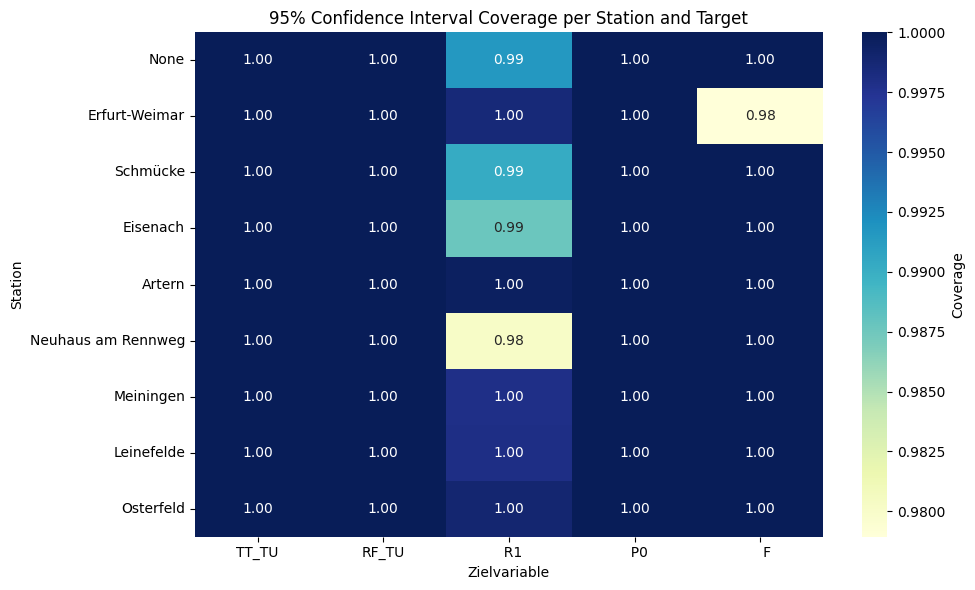

In [22]:
coverage_matrix = {}

for station_name, result in results_dict.items():
    model = result["model"]
    X_test = torch.tensor(result["X_val_np"], dtype=torch.float32)
    y_test = torch.tensor(result["y_val_np"], dtype=torch.float32)

    # Batchweise Vorhersagen
    outputs = get_model_outputs_in_batches(model, X_test, batch_size=1024)

    # Alle means und stddevs zusammenführen
    all_means = torch.cat([o.mean for o in outputs], dim=0)
    all_stds = torch.cat([o.stddev for o in outputs], dim=0)

    lower = all_means - 2 * all_stds
    upper = all_means + 2 * all_stds

    coverages = []
    for i in range(all_means.shape[1]):
        inside = ((y_test[:, i] >= lower[:, i]) & (y_test[:, i] <= upper[:, i])).float().mean().item()
        coverages.append(inside)

    coverage_matrix[station_name] = coverages

# 🔥 Heatmap-Plot
coverage_df = pd.DataFrame.from_dict(coverage_matrix, orient="index", columns=targets)

plt.figure(figsize=(10, 6))
sns.heatmap(coverage_df, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Coverage'})
plt.title("95% Confidence Interval Coverage per Station and Target")
plt.xlabel("Zielvariable")
plt.ylabel("Station")
plt.tight_layout()
plt.show()

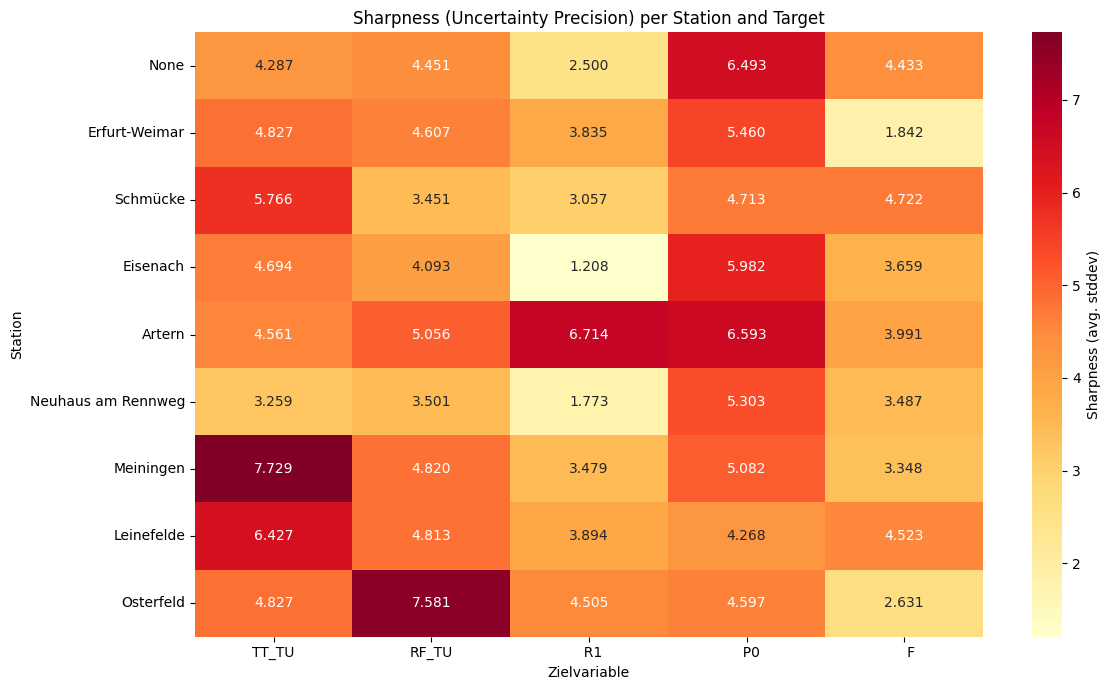

In [23]:
plot_sharpness_heatmap(results_dict, targets)

In [23]:
results_dict_top= {}
for station_name, result in results_dict.items():
    if station_name in ['Neuhaus am Rennweg', 'Erfurt-Weimar', 'None', 'Artern']:
        results_dict_top[station_name]= result

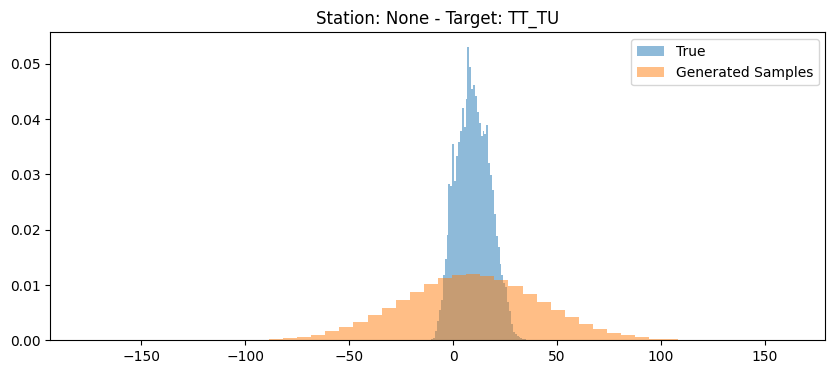

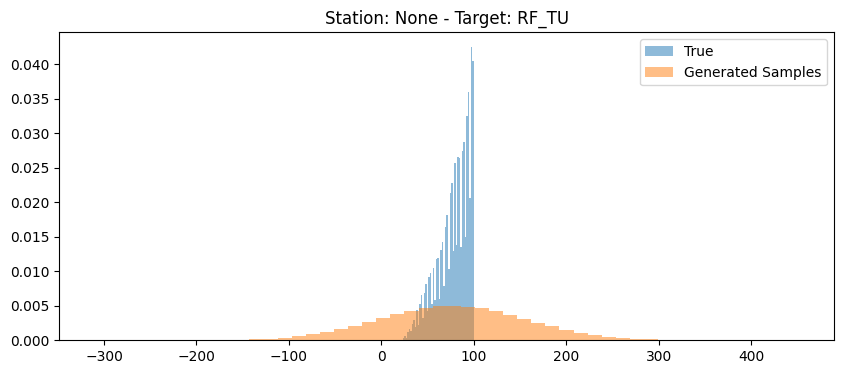

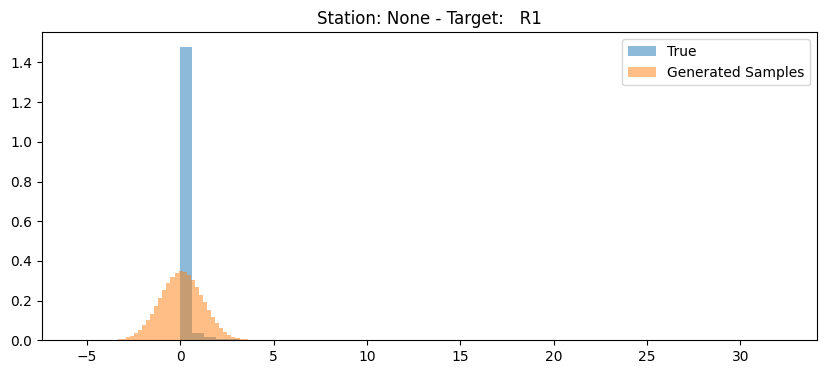

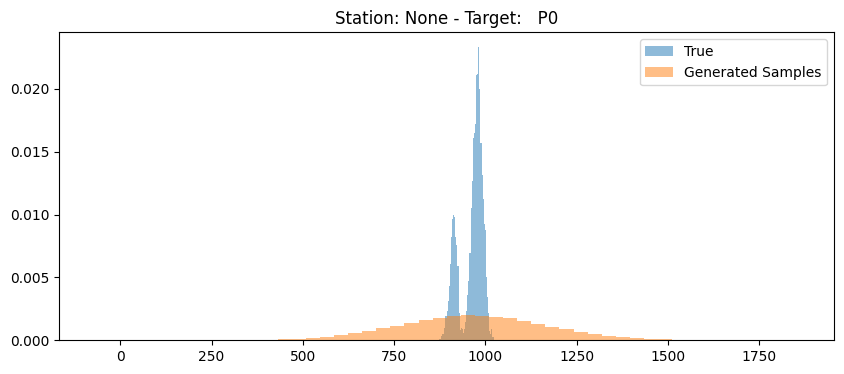

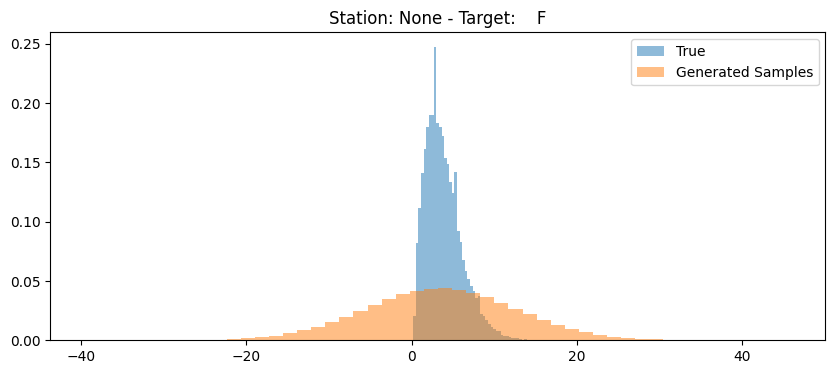

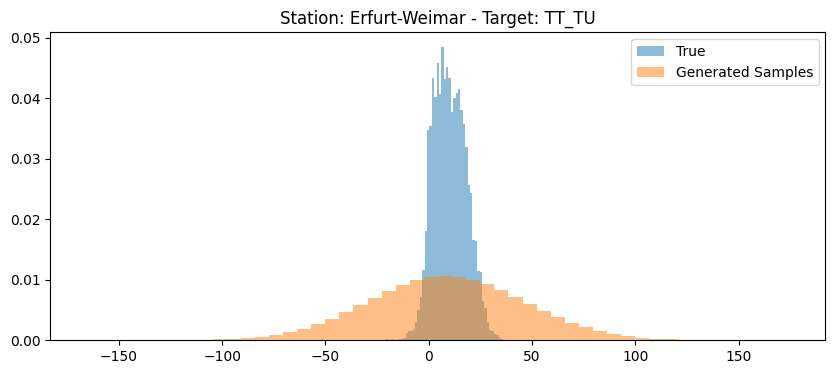

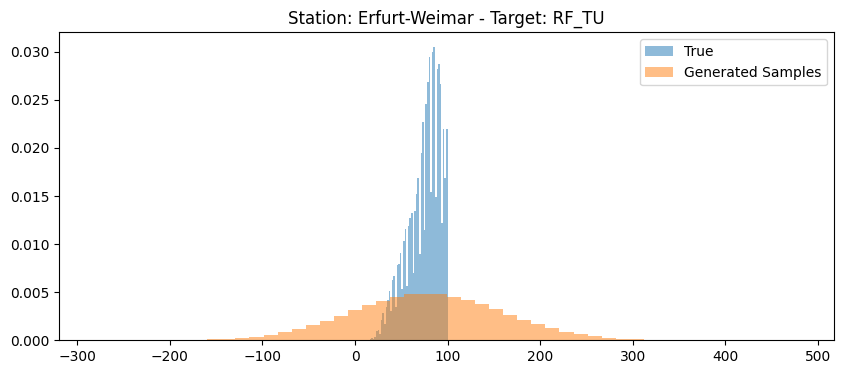

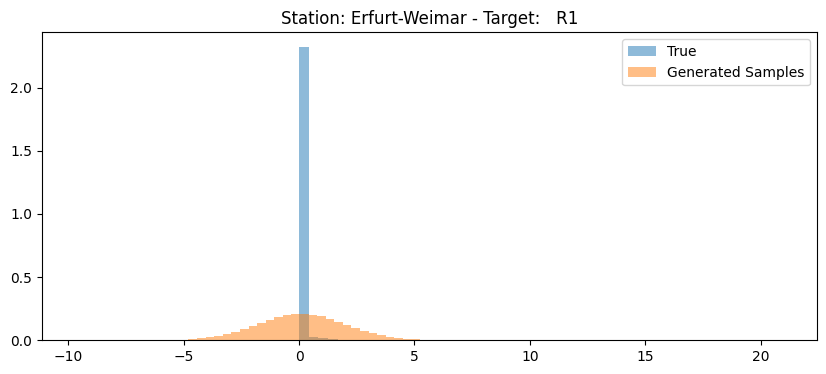

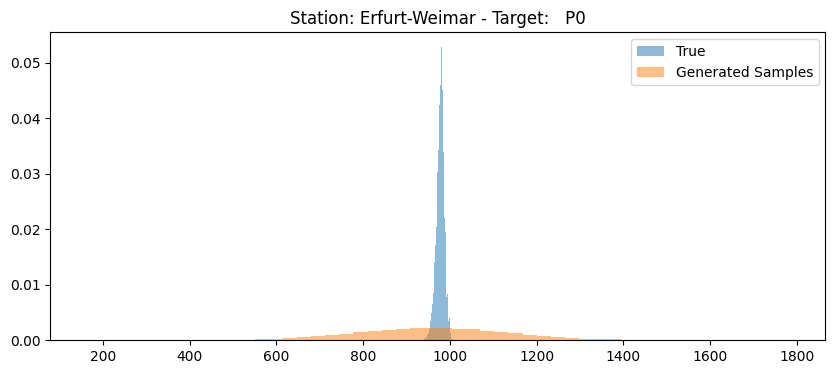

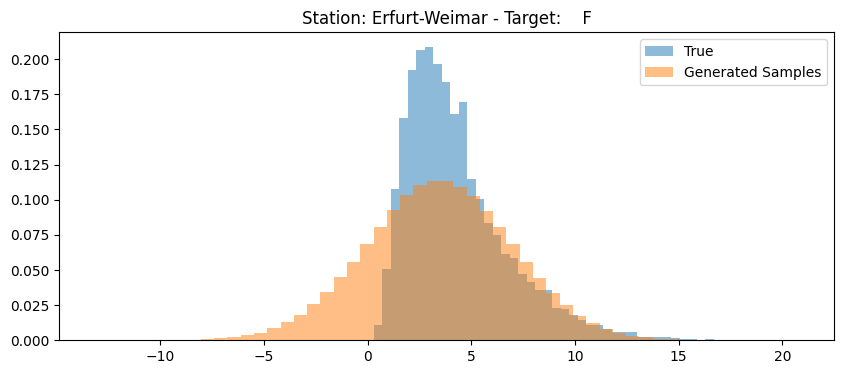

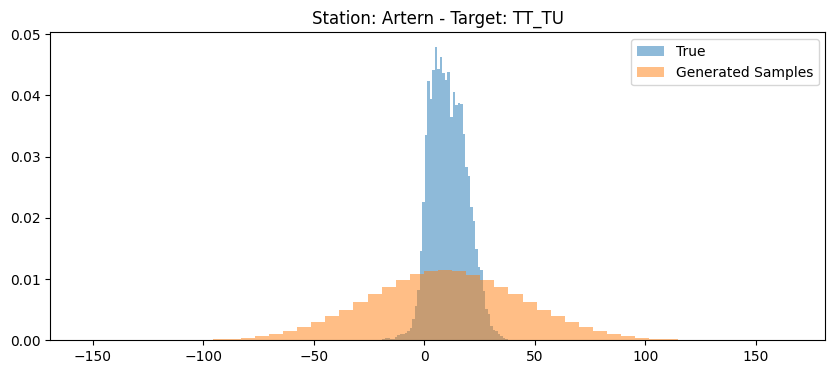

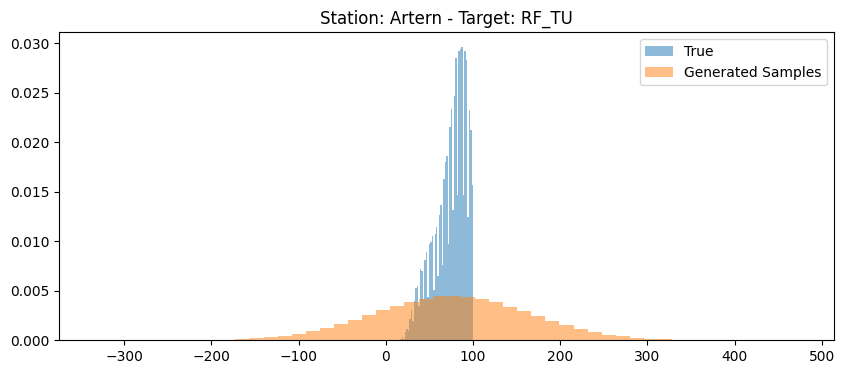

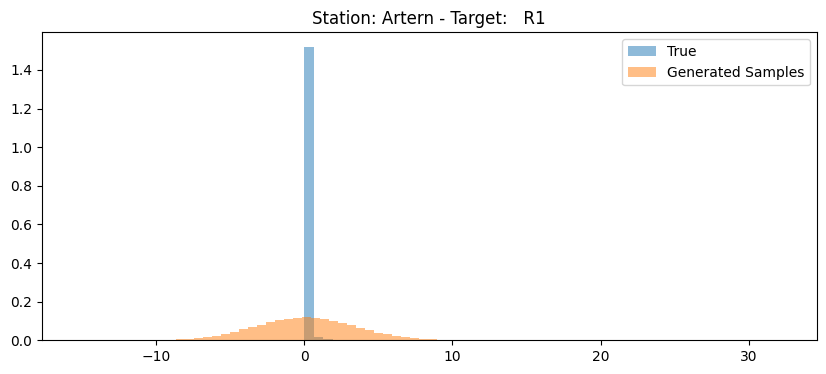

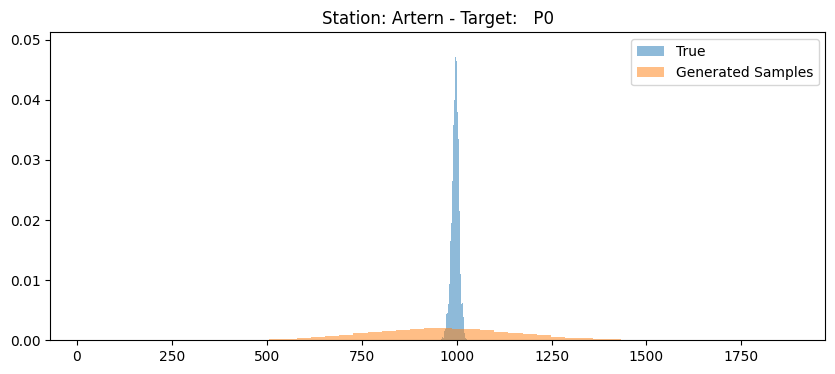

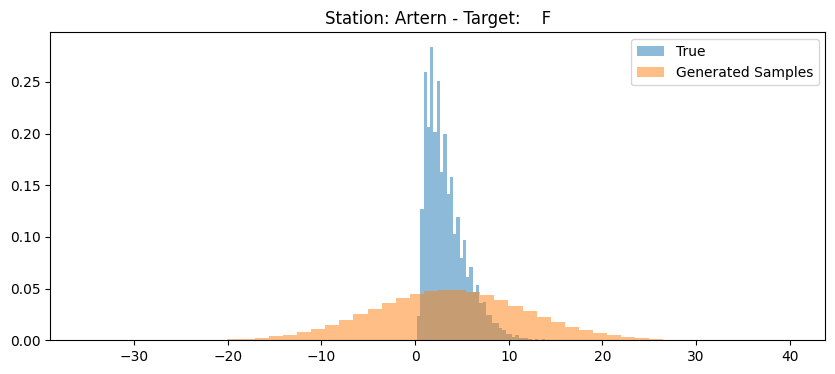

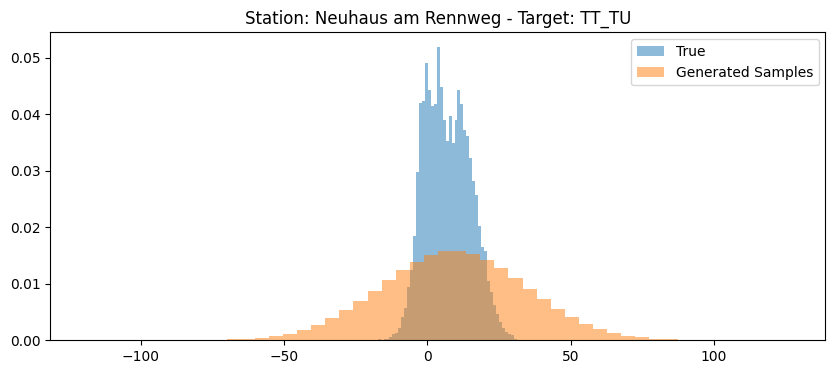

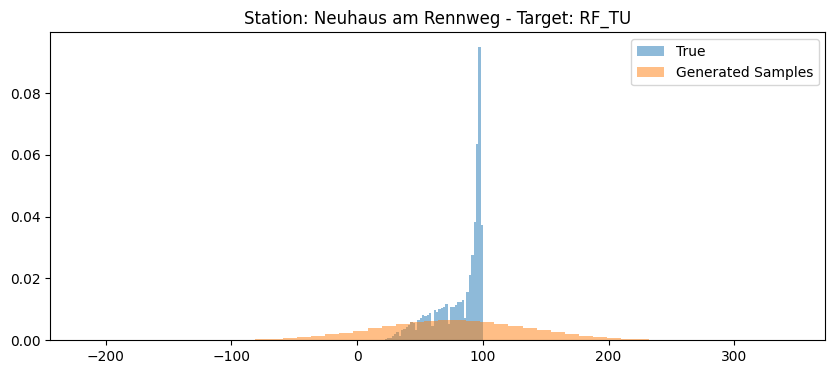

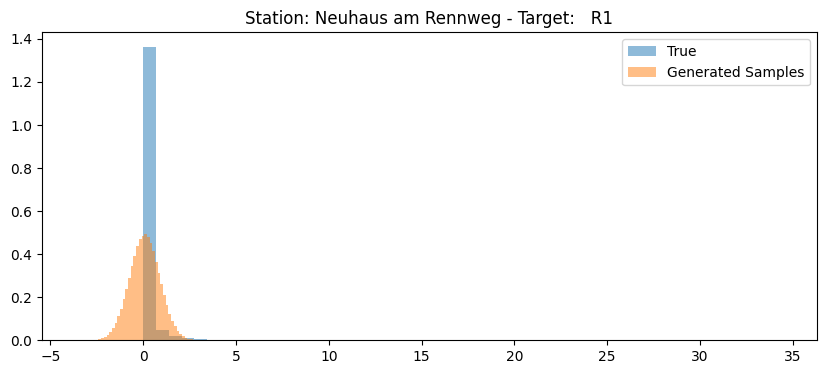

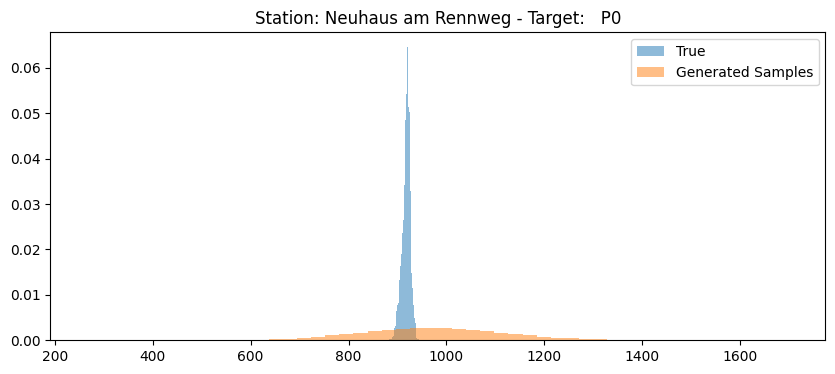

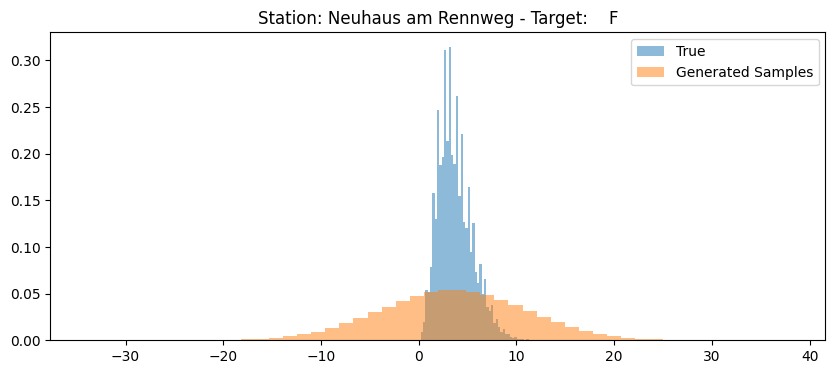

In [39]:
num_samples = 100  # Anzahl der Samples pro Inputpunkt

for station_name, result in results_dict_top.items():
    model = result["model"]
    scalerX = result["scalerX"]
    scalerY = result["scalerY"]
    
    # Testdaten (skalierte Inputs und true targets)
    X_val_np = result["X_val_np"]
    y_val_np = result["y_val_np"]
    
    # In Torch Tensor umwandeln
    X_val = torch.tensor(X_val_np, dtype=torch.float32).to(device)
    
    model.eval()
    with torch.no_grad():
        samples = get_model_samples_in_batches(model, X_val, num_samples=100, batch_size=512)
        
    # Samples skalieren (inverse transform)
    # samples: (num_samples, N, num_targets)
    samples_reshaped = samples.reshape(-1, samples.shape[2])  # (num_samples * N, num_targets)
    samples_orig = scalerY.inverse_transform(samples_reshaped)
    
    y_true_orig = scalerY.inverse_transform(y_val_np)
    
    for target_idx, target_name in enumerate(targets):
        plt.figure(figsize=(10, 4))
        plt.hist(y_true_orig[:, target_idx], bins=50, alpha=0.5, label="True", density=True)
        plt.hist(samples_orig[:, target_idx], bins=50, alpha=0.5, label="Generated Samples", density=True)
        plt.title(f"Station: {station_name} - Target: {target_name}")
        plt.legend()
        plt.show()

In [24]:
for  station, result in results_dict_top.items():

    model = result["model"]
    scalerY = result["scalerY"]
    df_train = result["df_train"]
    df_test = result["df_test"]

    # GP-Samples generieren
    X_tensor = torch.tensor(result["X_val_np"], dtype=torch.float32).to(device)
    samples = get_model_samples_in_batches(model, X_tensor, num_samples=100)

    # Mittelwert über die 100 Samples (→ realistische GP-Vorhersage)
    samples_mean = samples.mean(dim=0).cpu().numpy()  # [N, T]

    linearModels, real_mse, syn_mse = evaluate_gp_consistency_with_ridge(
        features=features,
        targets=targets,
        df_train=result["df_train"],
        df_test=result["df_test"],
        synthetic_samples=samples_mean,
        scalerY=result["scalerY"]
    )

    features = ['TT_TU', 'RF_TU', 'R1', 'P0', 'F']

    mseComparer = pd.DataFrame({
        'Feature': features,
        'MSE_Real': real_mse,
        'MSE_Synthetic': syn_mse,
    })
    mseComparer["Delta (%)"] = 100 * (mseComparer["MSE_Synthetic"] - mseComparer["MSE_Real"]) / mseComparer["MSE_Real"]

    print(mseComparer.round(4))

🎯 Target: TT_TU
  🔹 Real Test MSE:      56.3843
  🔸 Synthetic MSE:      17.8616

🎯 Target: RF_TU
  🔹 Real Test MSE:      278.6776
  🔸 Synthetic MSE:      91.2418

🎯 Target:   R1
  🔹 Real Test MSE:      0.3348
  🔸 Synthetic MSE:      0.0144

🎯 Target:   P0
  🔹 Real Test MSE:      95.7354
  🔸 Synthetic MSE:      1295.7980

🎯 Target:    F
  🔹 Real Test MSE:      5.0015
  🔸 Synthetic MSE:      1.1271

  Feature  MSE_Real  MSE_Synthetic  Delta (%)
0   TT_TU   56.3843        17.8616   -68.3217
1   RF_TU  278.6776        91.2418   -67.2590
2      R1    0.3348         0.0144   -95.7133
3      P0   95.7354      1295.7980  1253.5205
4       F    5.0015         1.1271   -77.4647


KeyError: "['R1', 'P0', 'F'] not in index"

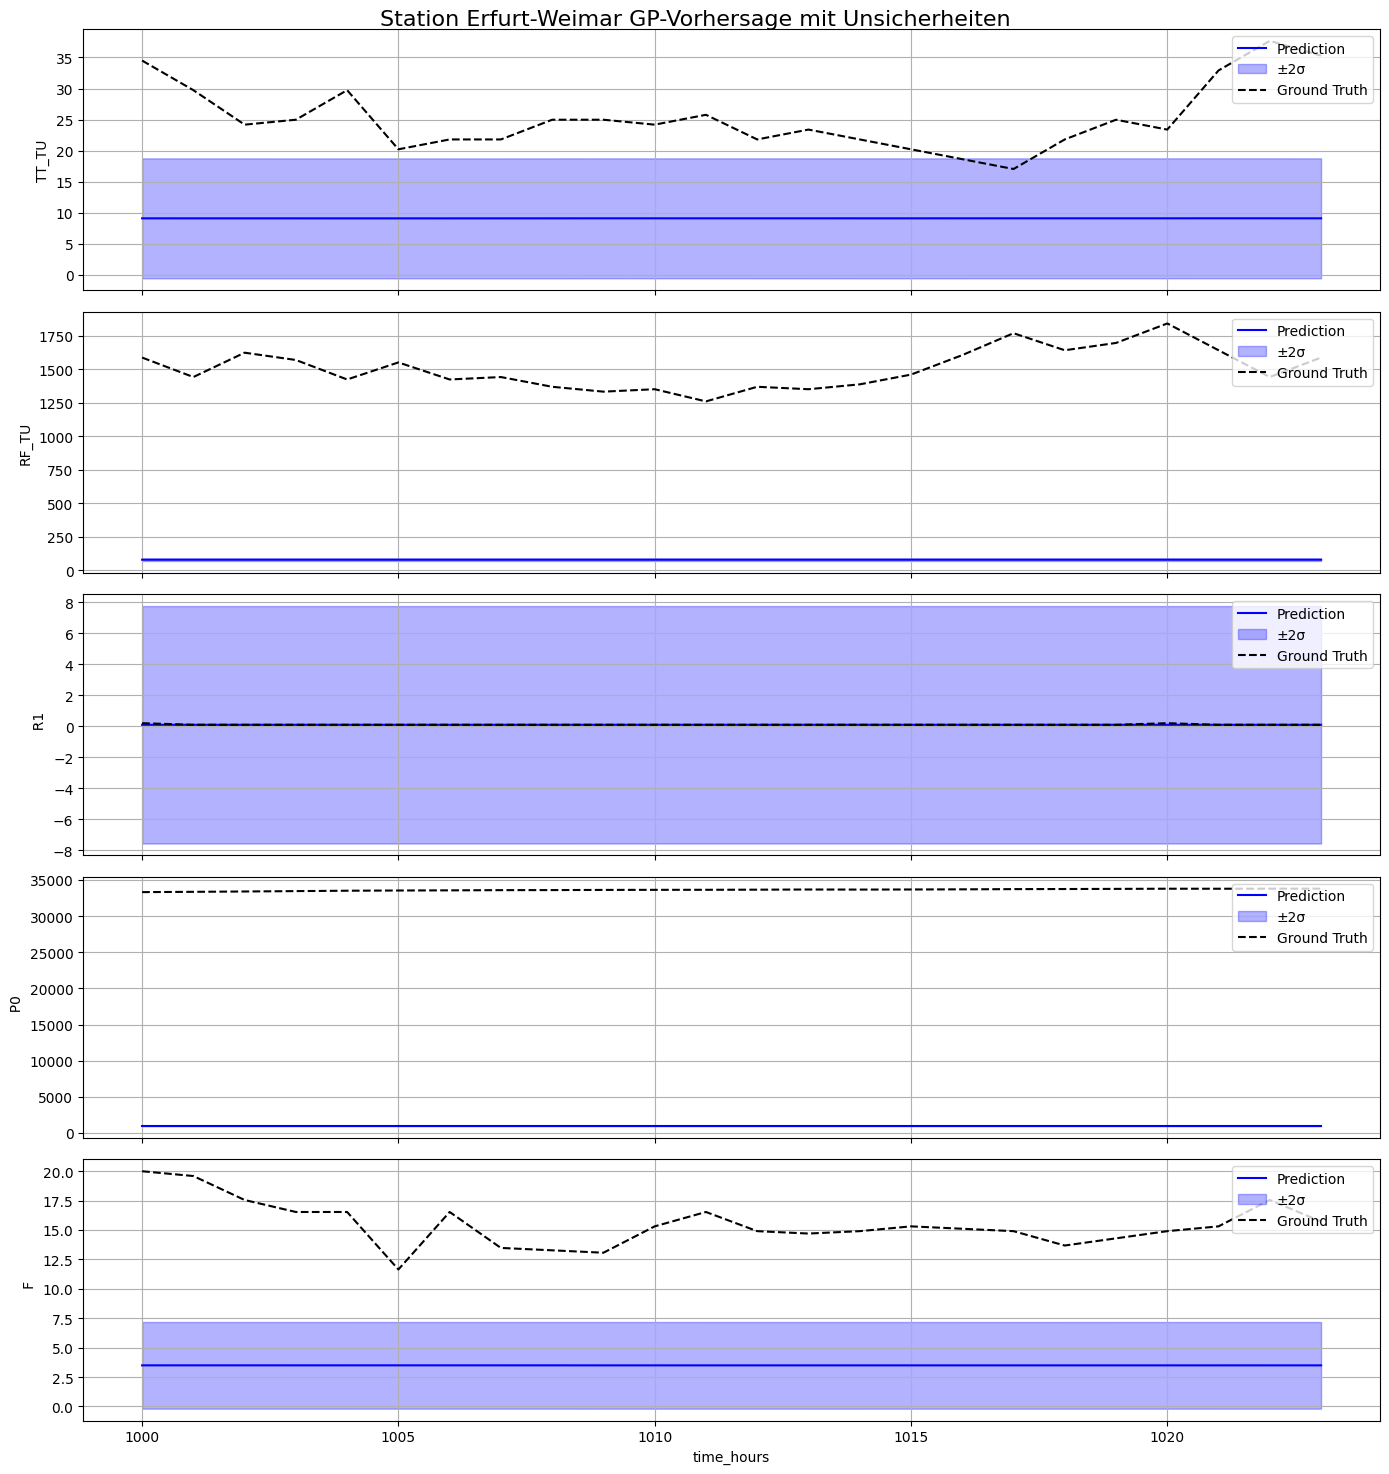

In [25]:
plot_gp_time_series_all_targets_counter(
    model=results_dict["Erfurt-Weimar"]["model"],
    likelihood=results_dict["Erfurt-Weimar"]["likelihood"],
    df_test=results_dict["Erfurt-Weimar"]["df_test"],
    scalerX=results_dict["Erfurt-Weimar"]["scalerX"],
    scalerY=results_dict["Erfurt-Weimar"]["scalerY"],
    features=features,
    targets=targets,
    start_counter= 1000,
    n_steps=24,
    title_prefix="Station Erfurt-Weimar"
)

In [47]:
for  station, result in results_dict_top.items():
    plot_gp_time_series_all_targets_counter(
        model=results_dict[station]["model"],
        likelihood=results_dict[station]["likelihood"],
        df_test=results_dict[station]["df_test"],
        scalerX=results_dict[station]["scalerX"],
        scalerY=results_dict[station]["scalerY"],
        features=features,
        targets=targets,
        start_counter= 1000,
        n_steps=24,
        title_prefix=f"Station {station}"
    )

KeyError: "['R1', 'P0', 'F'] not in index"